# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



1. Clean the data and perform some EDA and visualization to get to know the data set.

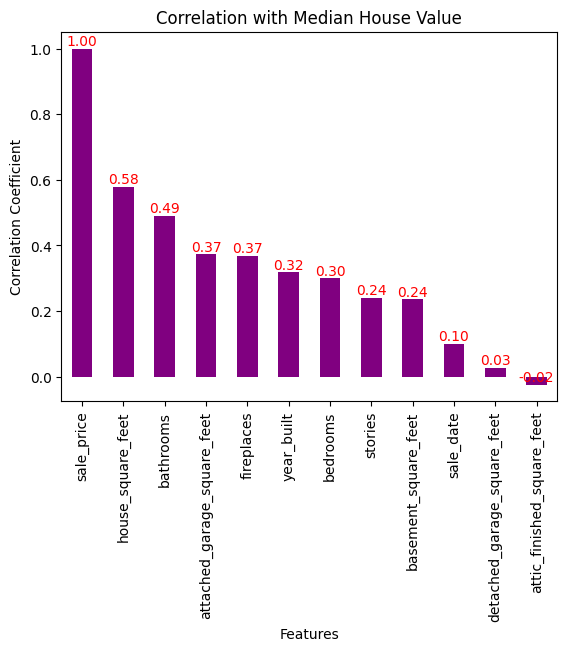

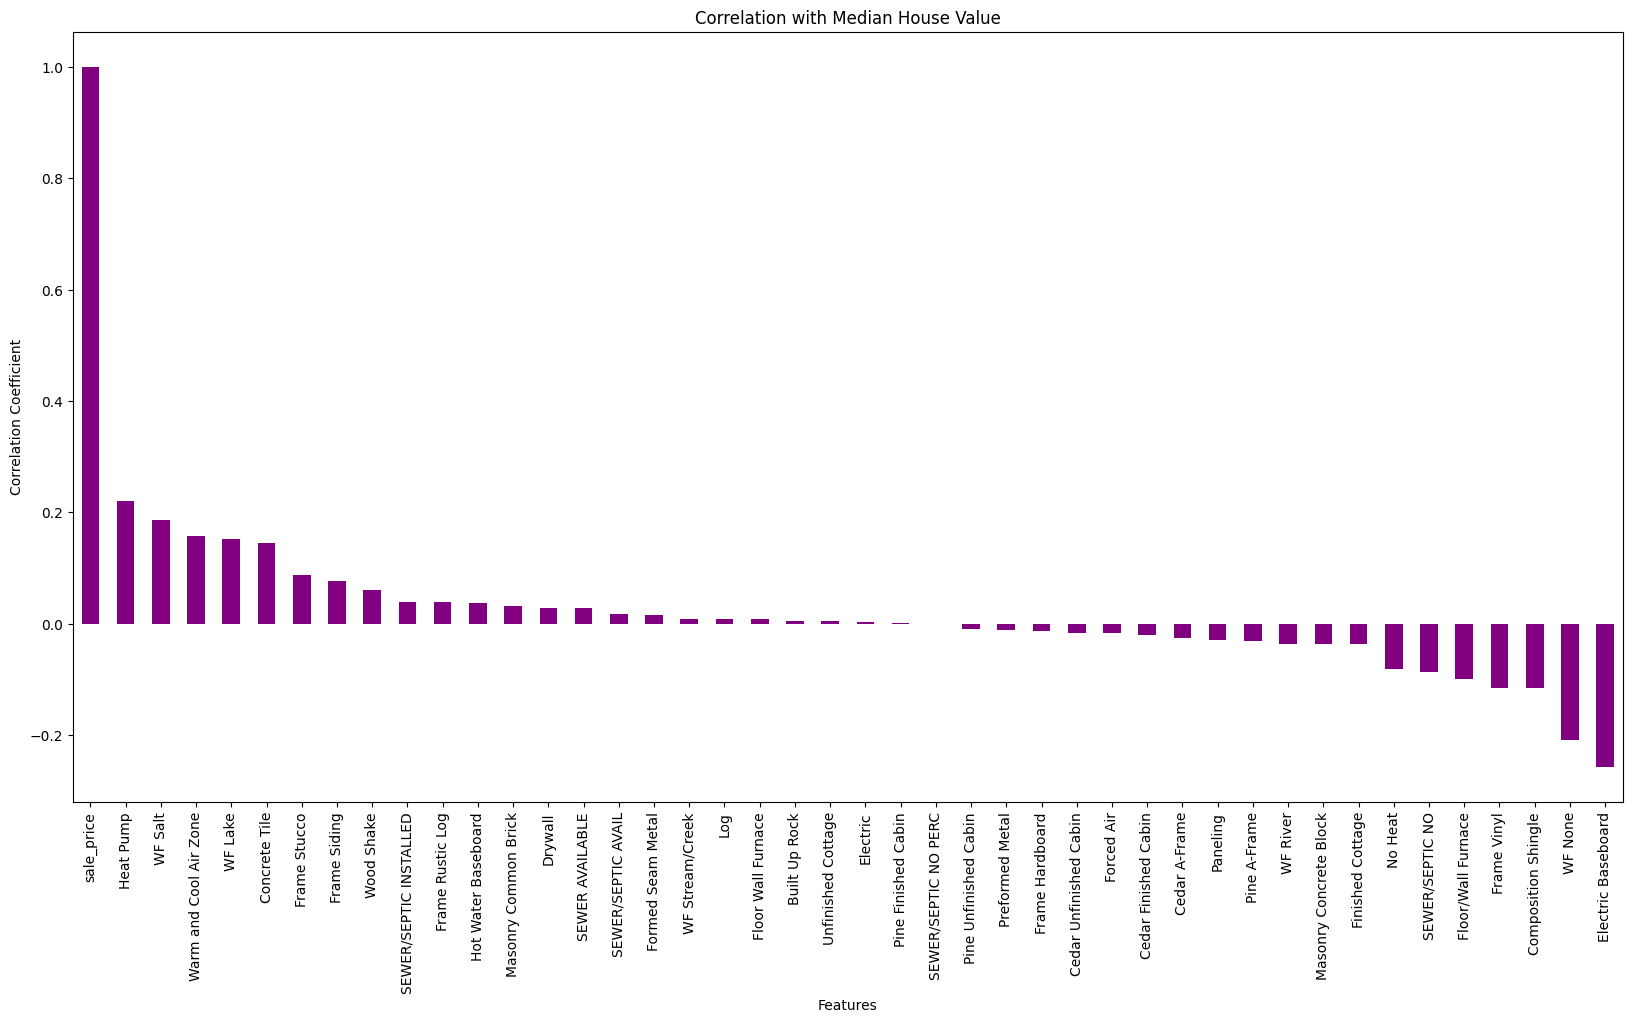

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("pierce_county_house_sales.csv")

df['waterfront_type'] = df['waterfront_type'].fillna('WF None')
df = df.drop(columns=['view_quality'])
df = df.dropna()
df.isnull().sum() # nice no more missing values

df['sale_date'] = df['sale_date'].str.replace('-', '').astype(int)
df['sale_price'] = np.log(df['sale_price'])

numeric_columns = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()
correlation_graph = corr_matrix['sale_price'].sort_values(ascending = False)
ax = correlation_graph.plot(kind='bar', color='purple')

for i, value in enumerate(correlation_graph):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='red')

ax.set_title('Correlation with Median House Value')
ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Features')

plt.show()


feature_cols = df.select_dtypes(include=['object']).columns
features = []
for col in list(feature_cols):
    features.append(pd.get_dummies(df[col], dtype='int'))

features = pd.concat(features, axis=1)
features_price = pd.concat([features, df['sale_price']], axis=1)

corr_matrix = features_price.corr()
correlation_graph = corr_matrix['sale_price'].sort_values(ascending = False)
ax = correlation_graph.plot(kind='bar', color='purple', figsize=(20,10))


ax.set_title('Correlation with Median House Value')
ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Features')

plt.show()


2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = df['sale_price']
X = df.drop(columns='sale_price')

# MODEL 1: Numerical Columns
X_numerical_cols = X.select_dtypes(include=['int64']).columns
X_numerical = X[X_numerical_cols]
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=100) 

reg = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat = reg.predict(X_test)
print('R-squared for numerical columns: ', reg.score(X_test,y_test)) 
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE for numerical columns: ', rmse) 


# MODEL 2: Categorical Columns
X_feature_cols = X.select_dtypes(include=['object']).columns
X_features = []
for col in list(X_feature_cols):
    X_features.append(pd.get_dummies(X[col], dtype='int'))

X_features = pd.concat(X_features, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=100) 

reg = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat = reg.predict(X_test)
print('\nR-squared for categorical columns: ', reg.score(X_test,y_test)) 
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE for categorical columns: ', rmse) 

# MODEL 3: All Columns
X_all = pd.concat([X_numerical, X_features], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=100) 

reg = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat = reg.predict(X_test)
print('\nR-squared for all columns: ', reg.score(X_test,y_test)) 
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE for all columns: ', rmse) 


R-squared for numerical columns:  0.46164291102369537
RMSE for numerical columns:  0.31042540202036106

R-squared for categorical columns:  0.23637591137055758
RMSE for categorical columns:  0.3697105503151784

R-squared for all columns:  0.5139418021897955
RMSE for all columns:  0.29496206856890195


5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [3]:
from sklearn.preprocessing import PolynomialFeatures

y = df['sale_price']
X = df.drop(columns='sale_price')

X_numerical_cols = X.select_dtypes(include=['int64']).columns
X_numerical = X[X_numerical_cols]

X_feature_cols = X.select_dtypes(include=['object']).columns
X_features = []
for col in list(X_feature_cols):
    X_features.append(pd.get_dummies(X[col], dtype='int'))
X_features = pd.concat(X_features, axis=1)

for d in range(1,6):
    expander = PolynomialFeatures(degree=d, include_bias=False)
    
    X_poly = expander.fit_transform(X_numerical)
    X_poly = pd.DataFrame(X_poly).reset_index(drop=True)

    X_feature = pd.DataFrame(X_features).reset_index(drop=True)
    
    X_poly_all = pd.concat([X_poly, X_feature], axis=1, ignore_index=True)

    X_train, X_test, y_train, y_test = train_test_split(X_poly_all, y, test_size=0.2, random_state=100) 
    
    reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    y_hat_temp = reg.predict(X_test)
    
    r_squared = reg.score(X_test, y_test)
    rmse = np.sqrt( np.mean( (y_test - y_hat_temp)**2 ))
    
    print(f'Degree: {d}, R^2: {r_squared}, RMSE: {rmse}')

Degree: 1, R^2: 0.513941802189795, RMSE: 0.29496206856890206
Degree: 2, R^2: 0.28658509401682586, RMSE: 0.3573494547286993
Degree: 3, R^2: 0.46507723803175016, RMSE: 0.30943367362258445
Degree: 4, R^2: 0.46507390914671065, RMSE: 0.309434636441516
Degree: 5, R^2: 0.46311256254635724, RMSE: 0.3100014000385856


6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?

My model did better using both the numerical and categorical columns and did not improve with any polynomial transformations. Looking at the correlation graphs at the beginning, it makes sense that the model that only used the categorical column did the worse as there was a stronger correlation with the numerical columns. At degree=2, it did the worse possibly indicating possible overfitting but I should look at the error within the training sets to confirm that it did much better using the training set than the testing set.

7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [12]:
from sklearn.linear_model import Lasso

y = df['sale_price']
X = df.drop(columns='sale_price')

X_numerical_cols = X.select_dtypes(include=['int64']).columns
X_numerical = X[X_numerical_cols]

X_feature_cols = X.select_dtypes(include=['object']).columns
X_features = []
for col in list(X_feature_cols):
    X_features.append(pd.get_dummies(X[col], dtype='int'))
X_features = pd.concat(X_features, axis=1)

X_all = pd.concat([X_numerical, X_features], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=100)

# Initialize and fit Lasso model
for a in [0.0001, 0.001, 0.01, 0.1, 1]: 
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)

    y_hat = lasso.predict(X_test)

    r_squared = lasso.score(X_test, y_test)
    rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))

    selected_features = X_all.columns[lasso.coef_ != 0]
    print(a)
    print("Selected features:", selected_features.tolist())
    print("R^2:", r_squared)
    print("RMSE:", rmse)
    print("")



0.0001
Selected features: ['sale_date', 'house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces', 'stories', 'year_built', 'bedrooms', 'bathrooms', 'Electric Baseboard', 'Floor/Wall Furnace', 'Forced Air', 'Heat Pump', 'No Heat', 'Warm and Cool Air Zone', 'Finished Cottage', 'Frame Rustic Log', 'Frame Siding', 'Frame Vinyl', 'Log', 'Masonry Concrete Block', 'Pine Finished Cabin', 'Unfinished Cottage', 'Drywall', 'Paneling', 'Built Up Rock', 'Composition Shingle', 'Concrete Tile', 'Formed Seam Metal', 'Preformed Metal', 'Wood Shake', 'WF Lake', 'WF River', 'WF Salt', 'WF Stream/Creek', 'SEWER AVAILABLE', 'SEWER/SEPTIC NO']
R^2: 0.5179701029106725
RMSE: 0.293737248142064

0.001
Selected features: ['sale_date', 'house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces', 'stories', 'year_built', 'bedrooms', '